In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initial data analysis:

total URLs: 549346
missing values:
 URL      0
Label    0
dtype: int64
                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad
5               smilesvoegol.servebbs.org/voegol.php   bad
6  premierpaymentprocessing.com/includes/boleto-2...   bad
7  myxxxcollection.com/v1/js/jih321/bpd.com.do/do...   bad
8                                super1000.info/docs   bad
9  horizonsgallery.com/js/bin/ssl1/_id/www.paypal...   bad


<Axes: xlabel='Label', ylabel='count'>

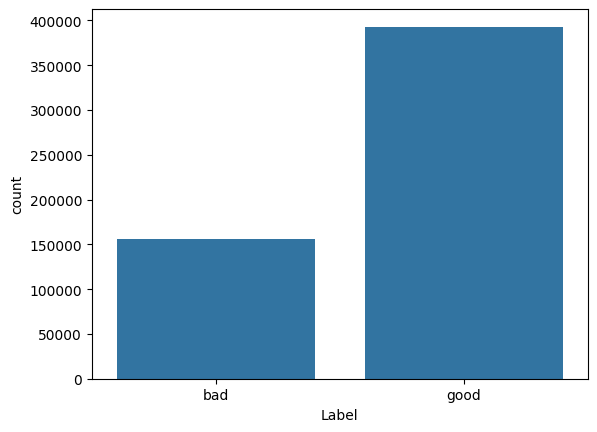

In [22]:
import pandas as pd
import seaborn as sns
df = pd.read_csv('/content/drive/MyDrive/Phishing project/phishing_site_urls.csv')
print(f"total URLs: {len(df)}")
print(f"missing values:\n {df.isna().sum()}")
print(df.head(10))
sns.countplot(data=df , x='Label')

fixing the data

In [23]:
bad_urls = df[df['Label']=='bad']
good_urls = df[df['Label']=='good']

good_urls = good_urls.sample(n=len(bad_urls), random_state=42)

df = pd.concat([good_urls, bad_urls])

start adding important features and parsing the URL.

In [24]:
from urllib.parse import urlparse

def extract_features(url):
  features = {}
  features['length'] = len(url)
  features['count_dots'] = url.count('.')
  features['count_dashes'] = url.count('-')
  features['has_https'] = int(url.startswith('https'))
  features['has_at'] = int('@' in url)
  features['has_www'] = int(url.startswith('www'))
  features['has_ip'] = int(url.replace('.', '').isdigit()) # Simple check for IP address
  parsed_url = urlparse(url)
  features['num_of_subdomains'] = len(parsed_url.hostname.split('.')) if parsed_url.hostname else 0
  features['path_slashes'] = parsed_url.path.count('/')
  features['double_slash_in_path'] = int('//' in parsed_url.path)

  return features

features_list = df['URL'].apply(extract_features)
x_features = pd.DataFrame(features_list.tolist())
y_features = df['Label']

Splitting the data into training and testing and train the model

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix, classification_report, precision_score, recall_score, f1_score

x_train, x_test, y_train, y_test = train_test_split(x_features, y_features, test_size=0.2, random_state=42)

# Fill missing values with 0
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model resaults:

              precision    recall  f1-score   support

         bad       0.63      0.58      0.60     31337
        good       0.61      0.65      0.63     31232

    accuracy                           0.62     62569
   macro avg       0.62      0.62      0.62     62569
weighted avg       0.62      0.62      0.62     62569



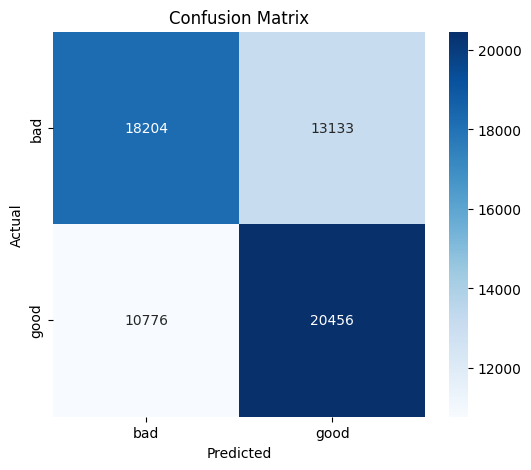

<Axes: >

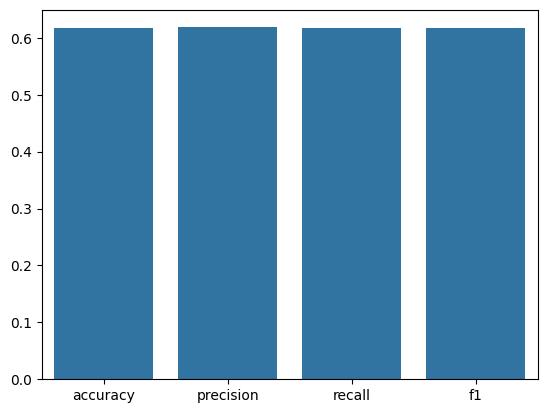

In [33]:
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
classes = ['bad', 'good']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
scores = {"accuracy":accuracy_score(y_test, y_pred),"precision": precision_score(y_test, y_pred, average='weighted'),"recall": recall_score(y_test, y_pred, average='weighted'),"f1": f1_score(y_test, y_pred, average='weighted')}
sns.barplot(data=scores)

In [35]:
#saving the model
import joblib

joblib.dump(model, "/content/drive/MyDrive/Phishing project/phishing_model.pkl")

['/content/drive/MyDrive/Phishing project/phishing_model.pkl']